In [1]:
def sample_k(a, probs):
    n = a.shape[0] - 1
    k = a.shape[1] - 1

    j = k
    sample = np.empty([n], dtype=int)
    for i in np.arange(n, 0, -1):

        # Unnormalized probabilities of Xi and -Xi
        z = a[i, j]
        p = (a[i-1, j-1] + probs[i-1]) - z

        # Sample according to normalized dist.
        X = np.random.binomial(1, np.exp(p))

        # Pick next state based on value of sample
        j = j-1 if X > 0 else j

        # Concatenate to samples: preallocating and slicing
        # should be faster than concatenating/stacking
        sample[i-1] = X

    # Our samples should always satisfy the constraint
    assert(np.sum(sample) == k - 1)
    return sample

In [2]:
import torch
torch.set_default_dtype(torch.float64)

from torch import Tensor
def log1mexp(x):
    return torch.where(x < 0.6931471805599453094, torch.log(-torch.expm1(-x)), torch.log1p(-torch.exp(-x)))

def logaddexp(x: Tensor, y: Tensor) -> Tensor:
    with torch.no_grad():
        m = torch.maximum(x, y)
        m = m.masked_fill_(torch.isneginf(m), 0.)

    z = (x - m).exp_() + (y - m).exp_()
    mask = z == 0
    z = z.masked_fill_(mask, 1.).log_().add_(m)
    z = z.masked_fill_(mask, -float('inf'))

    return z

# def pr_exactly_k(probs, k, log_space=True):
#     """
#     probs: a tensor of shape: (batch_size, num_vars)
#     where probs[:, i] corresponds to the batch probabilities
#     of Bernoulli variable Xi

#     if log_space=True, we expect log_probabilities as input
#     """
#     probs = torch.from_numpy(probs)
#     probs.requires_grad_()
    
#     n = probs.shape[0]

#     # a[:, i, j] = Pr(Sum(X1, ... , Xi) = j)
#     # Note: a[:, 0, 0] corresponds to the Pr
#     # that an empty sequence summing up to -1
#     # which is always 0
#     a = torch.full((n+1, k+2), -torch.inf)

#     # The probability of an empty sequence
#     # summing to 0 is 1
#     a[:, 0, 1] = 0
    
#     for i in range(1, n+1):
#         # To get a sequence of length i with only
#         # j true variables, I either take a seq.
#         # with k true variables, and set variable
#         # i to false, or take a sequence with k-1
#         # true variables and set variable i to true
#         a[:, i, 1:] = logaddexp(a[:, i-1, :-1] + probs[:, i-1:i],  a[:, i-1, 1:] + log1mexp(-probs[:, i-1:i].detach()))
    
#     # backward to compute marginals
#     a[-1][-1].mean().backward()

#     return a, probs.grad


def pr_exactly_k(probs, k, log_space=True):
    """
    probs: a tensor of shape: (batch_size, num_vars)
    where probs[:, i] corresponds to the batch probabilities
    of Bernoulli variable Xi

    if log_space=True, we expect log_probabilities as input
    """
    probs = torch.from_numpy(probs)
    probs.requires_grad_()
    
    n = probs.shape[0]

    # a[:, i, j] = Pr(Sum(X1, ... , Xi) = j)
    # Note: a[:, 0, 0] corresponds to the Pr
    # that an empty sequence summing up to -1
    # which is always 0
    if log_space:
        a = torch.full((n+1, k+2), -torch.inf)
    else:
        a = torch.zeros((n+1, k+2))

    # The probability of an empty sequence
    # summing to 0 is 1
    a[0, 1] = 0 if log_space else 1
    for i in range(1, n+1):

        # To get a sequence of length i with only
        # j true variables, I either take a seq.
        # with k true variables, and set variable
        # i to false, or take a sequence with k-1
        # true variables and set variable i to true
        if log_space:
            a[i, 1:] = logaddexp(a[i-1, :-1] + probs[i-1:i],  a[i-1, 1:] + log1mexp(-probs[i-1:i].detach()))
        else:
            a[i, 1:] =  a[i-1, :-1].clone() * probs[i-1] + a[i-1, 1:].clone() * (1 - probs[i-1]).detach()
    a[-1][-1].mean().backward()

    return a, probs.grad

In [3]:
# def log1mexp(x):
#     return np.where(x < 0.6931471805599453094, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))

def logsigmoid(x):
    return -np.logaddexp(0, -x)

def pr_exactly_k_np(probs, k, log_space=True):
    """
    probs: a tensor of shape: (batch_size, num_vars)
    where probs[:, i] corresponds to the batch probabilities
    of Bernoulli variable Xi

    if log_space=True, we expect log_probabilities as input
    """
    n = probs.shape[0]

    # a[:, i, j] = Pr(Sum(X1, ... , Xi) = j)
    # Note: a[:, 0, 0] corresponds to the Pr
    # that an empty sequence summing up to -1
    # which is always 0
    if log_space:
        a = np.full((n+1, k+2), -np.inf)
    else:
        a = np.zeros((n+1, k+2))

    # The probability of an empty sequence
    # summing to 0 is 1
    a[0, 1] = 0 if log_space else 1
    for i in range(1, n+1):

        # To get a sequence of length i with only
        # j true variables, I either take a seq.
        # with k true variables, and set variable
        # i to false, or take a sequence with k-1
        # true variables and set variable i to true
        if log_space:
            a[i, 1:] = np.logaddexp(a[i-1, :-1] + probs[i-1],  a[i-1, 1:] + log1mexp(-probs[i-1]))
        else:
            a[i, 1:] =  a[i-1, :-1] * probs[i-1] + a[i-1, 1:] * (1 - probs[i-1])

    return a

In [4]:
import warnings

import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ridge_regression
from sklearn.utils.validation import check_is_fitted

from pysindy.optimizers.base import BaseOptimizer


class STLSQ_(BaseOptimizer):
    """Sequentially thresholded least squares algorithm. Defaults to doing
    Sequentially thresholded Ridge regression.

    Attempts to minimize the objective function
    :math:`\\|y - Xw\\|^2_2 + \\alpha \\|w\\|^2_2`
    by iteratively performing least squares and masking out
    elements of the weight array w that are below a given threshold.

    See the following reference for more details:

        Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz.
        "Discovering governing equations from data by sparse
        identification of nonlinear dynamical systems."
        Proceedings of the national academy of sciences
        113.15 (2016): 3932-3937.

    Parameters
    ----------
    threshold : float, optional (default 0.1)
        Minimum magnitude for a coefficient in the weight vector.
        Coefficients with magnitude below the threshold are set
        to zero.

    alpha : float, optional (default 0.05)
        Optional L2 (ridge) regularization on the weight vector.

    max_iter : int, optional (default 20)
        Maximum iterations of the optimization algorithm.

    ridge_kw : dict, optional (default None)
        Optional keyword arguments to pass to the ridge regression.

    fit_intercept : boolean, optional (default False)
        Whether to calculate the intercept for this model. If set to false, no
        intercept will be used in calculations.

    normalize_columns : boolean, optional (default False)
        Normalize the columns of x (the SINDy library terms) before regression
        by dividing by the L2-norm. Note that the 'normalize' option in sklearn
        is deprecated in sklearn versions >= 1.0 and will be removed.

    copy_X : boolean, optional (default True)
        If True, X will be copied; else, it may be overwritten.

    initial_guess : np.ndarray, shape (n_features) or (n_targets, n_features),
            optional (default None)
        Initial guess for coefficients ``coef_``.
        If None, least-squares is used to obtain an initial guess.

    verbose : bool, optional (default False)
        If True, prints out the different error terms every iteration.

    Attributes
    ----------
    coef_ : array, shape (n_features,) or (n_targets, n_features)
        Weight vector(s).

    ind_ : array, shape (n_features,) or (n_targets, n_features)
        Array of 0s and 1s indicating which coefficients of the
        weight vector have not been masked out, i.e. the support of
        ``self.coef_``.

    history_ : list
        History of ``coef_``. ``history_[k]`` contains the values of
        ``coef_`` at iteration k of sequentially thresholded least-squares.

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.integrate import odeint
    >>> from pysindy import SINDy
    >>> from pysindy.optimizers import STLSQ
    >>> lorenz = lambda z,t : [10*(z[1] - z[0]),
    >>>                        z[0]*(28 - z[2]) - z[1],
    >>>                        z[0]*z[1] - 8/3*z[2]]
    >>> t = np.arange(0,2,.002)
    >>> x = odeint(lorenz, [-8,8,27], t)
    >>> opt = STLSQ(threshold=.1, alpha=.5)
    >>> model = SINDy(optimizer=opt)
    >>> model.fit(x, t=t[1]-t[0])
    >>> model.print()
    x0' = -9.999 1 + 9.999 x0
    x1' = 27.984 1 + -0.996 x0 + -1.000 1 x1
    x2' = -2.666 x1 + 1.000 1 x0
    """

    def __init__(
        self,
        threshold=0.1,
        alpha=0.05,
        max_iter=1000,
        ridge_kw=None,
        normalize_columns=False,
        fit_intercept=False,
        copy_X=True,
        initial_guess=None,
        verbose=False,
        k=3,
        lr=1.0,
        _lambda=1.0
    ):
        super(STLSQ_, self).__init__(
            max_iter=max_iter,
            fit_intercept=fit_intercept,
            copy_X=copy_X,
            normalize_columns=normalize_columns,
        )

        if threshold < 0:
            raise ValueError("threshold cannot be negative")
        if alpha < 0:
            raise ValueError("alpha cannot be negative")

        self.threshold = threshold
        self.alpha = alpha
        self.ridge_kw = ridge_kw
        self.initial_guess = initial_guess
        self.verbose = verbose
        self.k = k
        self.lr = lr
        self._lambda = _lambda

#     def _sparse_coefficients(self, dim, ind, coef, threshold):
#         """Perform thresholding of the weight vector(s)"""
#         print("Sparsifying Coefficients")
        
# #         # Sampling exactly k
# #         probs = logsigmoid(self.logits)
# #         pr_k = pr_exactly_k(probs, self.k)
# #         marginals = pr_k[-1][-1].mean().backward()
# #         sample = sample_k(pr_k.detach().numpy(), probs) 
        
#         c = np.zeros(dim)
#         c[ind] = coef
#         big_ind = sample != 0
#         c[~big_ind] = 0
#         return c, big_ind

    def _sparse_coefficients(self, dim, ind, coef, threshold):
        """Perform thresholding of the weight vector(s)"""
        c = np.zeros(dim)
        c[ind] = coef
        big_ind = np.abs(c) >= threshold
        c[~big_ind] = 0
        return c, big_ind

    def _regress(self, x, y):
        """Perform the ridge regression"""
        kw = self.ridge_kw or {}
        coef = ridge_regression(x, y, self.alpha, **kw)
        self.iters += 1
        return coef
    
#     def _imle(self, x, y):
        
#         p = logsigmoid(self.logits)
#         a_p = pr_exactly_k(p, self.k)
#         marginals_p = a_p[-1][-1].backward()
#         p_sample = sample_k(a_p.detach().numpy(), probs) 
        
#         # perturb p to get q
#         q = self.logits - _lambda*(p_sample*coef*x - y)*(coef*x)
        
#         # get the gradient
#         a_q = pr_exactly_k(q, self.k)
#         marginals_q = a_q[-1][-1].backward()
#         grad = marginals_p - marginals_q
        
#         # update
#         self.logits = self.logits - lr * grad
        
    def _imle_fwd(self):
        p = logsigmoid(self.logits)
#         p = np.broadcast_to(p, (257024, 14))
        a_p, self.fwd_marginals = pr_exactly_k(p, self.k)

#         self.fwd_marginals = p.grad

        self.fwd_sample = sample_k(a_p.detach().numpy(), p)

        
        
    def _imle_bwd(self, x, y, coef):
        
        # perturb p to get q
        n_samples = y.shape[0]
        coef_x = np.matmul(x, coef)
        diff = coef_x - y.reshape(n_samples)
        diff = diff.reshape(-1, 1)
        tmp = diff * x
        tmp_grad = tmp.mean(axis=0)
        perturb = tmp_grad * coef
        q = self.logits - self._lambda * 2 * perturb
        q = logsigmoid(q)
        
        # get the gradient
        a_q, marginals_q = pr_exactly_k(q, self.k)
#         a_q[-1][-1].mean().backward()
#         marginals_q = q.grad
        grad = self.fwd_marginals - marginals_q
        
        # update
        self.logits = self.logits - self.lr * grad.detach().numpy()
        

    def _no_change(self):
        """Check if the coefficient mask has changed after thresholding"""
        this_coef = self.history_[-1].flatten()
        if len(self.history_) > 1:
            last_coef = self.history_[-2].flatten()
        else:
            last_coef = np.zeros_like(this_coef)
        return all(bool(i) == bool(j) for i, j in zip(this_coef, last_coef))

    def _reduce(self, x, y):
        """Performs at most ``self.max_iter`` iterations of the
        sequentially-thresholded least squares algorithm.

        Assumes an initial guess for coefficients and support are saved in
        ``self.coef_`` and ``self.ind_``.
        """
        if self.initial_guess is not None:
            self.coef_ = self.initial_guess

        ind = self.ind_
        n_samples, n_features = x.shape
        n_targets = y.shape[1]
        n_features_selected = np.sum(ind)
        
#         self.logits =np.random.rand(n_features)# np.ones(n_features, dtype=float)
        self.logits = np.ones(n_features, dtype=float)

        # Print initial values for each term in the optimization
        if self.verbose:
            row = [
                "Iteration",
                "|y - Xw|^2",
                "a * |w|_2",
                "|w|_0",
                "Total error: |y - Xw|^2 + a * |w|_2",
            ]
            print(
                "{: >10} ... {: >10} ... {: >10} ... {: >10}"
                " ... {: >10}".format(*row)
            )
        
        for k in range(self.max_iter):
            if np.count_nonzero(ind) == 0:
                warnings.warn(
                    "Sparsity parameter is too big ({}) and eliminated all "
                    "coefficients".format(self.threshold)
                )
                coef = np.zeros((n_targets, n_features))
                break

            coef = np.zeros((n_targets, n_features))
            for i in range(n_targets):
                if np.count_nonzero(ind[i]) == 0:
                    warnings.warn(
                        "Sparsity parameter is too big ({}) and eliminated all "
                        "coefficients".format(self.threshold)
                    )
                    continue
                
                
                # Sample a mask of exactly-k features
                self._imle_fwd()
                
                # Use the selected features to solve the ridge regression
                mask = self.fwd_sample != 0
                                    
                mask = np.broadcast_to(mask, (257024, 14))

                coef_i = self._regress(np.reshape(x[:][mask], (-1, self.k)), y[:, i])
                
                coef[i][mask[0]] = coef_i
                ind[i] = mask[0]
                
                # Update the logits using imle
                self._imle_bwd(x, y, coef[i,:]) # coef[i, :].shape should be num_features
                                
#                 coef_i, ind_i = self._sparse_coefficients(
#                     n_features, ind[i], coef_i, self.threshold
#                 )
#                 coef[i][mask[0]] = coef_i
#                 print("coef", coef_i)

# #                 coef[i] = coef_i
#                 ind[i] = mask[0]

            self.history_.append(coef)
            if self.verbose:
                R2 = np.sum((y - np.dot(x, coef.T)) ** 2)
                L2 = self.alpha * np.sum(coef ** 2)
                L0 = np.count_nonzero(coef)
                row = [k, R2, L2, L0, R2 + L2]
                print(
                    "{0:10d} ... {1:10.4e} ... {2:10.4e} ... {3:10d}"
                    " ... {4:10.4e}".format(*row)
                )
#             if np.sum(ind) == n_features_selected or self._no_change():
                # could not (further) select important features
#                 break
        else:
            warnings.warn(
                "STLSQ._reduce did not converge after {} iterations.".format(
                    self.max_iter
                ),
                ConvergenceWarning,
            )
            try:
                coef
            except NameError:
                coef = self.coef_
                warnings.warn(
                    "STLSQ._reduce has no iterations left to determine coef",
                    ConvergenceWarning,
                )
        self.ind_ = self.logits.argsort()[-self.k:]
        mask = np.zeros(n_features, dtype=int)
        mask[self.ind_] = 1
        mask = np.broadcast_to(mask, (257024, 14))
        self.coef_ = self._regress(np.reshape(x[:][mask!=0], (-1, self.k)), y[:, i])
        
        coef = np.zeros((n_features))
        coef[mask[0]!=0] = self.coef_
        self.coef_ = coef
        
#         self.ind_ = ind

    @property
    def complexity(self):
        print("Complexity")
        check_is_fitted(self)

        return np.count_nonzero(self.coef_) + np.count_nonzero(
            [abs(self.intercept_) >= self.threshold]
        )


In [5]:
# Plot Kuramoto-Sivashinsky data and its derivative
def plot_u_and_u_dot(t, x, u):
    dt = t[1] - t[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(t, x, u[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    plt.title(r"$u(x, t)$", fontsize=16)
    u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(t, x, u_dot[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r"$\dot{u}(x, t)$", fontsize=16)
    plt.show()
    return u_dot

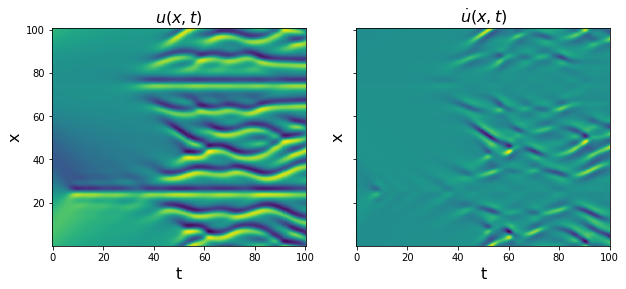

In [6]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

# Load data from .mat file
data = loadmat('kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
dt = t[1] - t[0]
x = np.ravel(data['x'])
u = data['uu']
u = u.reshape(len(x), len(t), 1)
u_dot = plot_u_and_u_dot(t, x, u)

In [7]:
import itertools
import random
def run():
    lambdas = [1e4, 1e3, 1e2, 1e1, 1e-1, 1e-2, 1e-3, 1e-4]
    lrs = [1e3, 1e2, 1e1, 1e-1, 1e-2, 1e-3, 1e-4]
    
#     lambdas = [1e1]
#     lrs = [1e1]
    for _lambda, lr in itertools.product(lambdas, lrs): 
        print(f"_lambda  = {_lambda}, lr = {lr}")
        random.seed(1234)
        torch.manual_seed(1234)
        np.random.seed(1234)
        
        # Define PDE library that is quadratic in u,
        # and fourth-order in spatial derivatives of u.
        library_functions = [lambda x: x, lambda x: x * x]
        library_function_names = [lambda x: x, lambda x: x + x]
        pde_lib = ps.PDELibrary(
            library_functions=library_functions,
            function_names=library_function_names,
            derivative_order=4,
            spatial_grid=x,
            is_uniform=True,
        )

        # Again, loop through all the optimizers
        print('STLSQ model: ')
        optimizer = STLSQ_(threshold=30, normalize_columns=True, k=3, lr=lr, _lambda=_lambda)
        model = ps.SINDy(feature_library=pde_lib,
                         feature_names=['u'],
                         optimizer=optimizer)
        model.fit(u, t=dt)
        model.print(precision=8)
    
    

In [8]:
run()# = -0.994 u_11 + -0.996 u_1111 + -0.992 uu_1 with idx 3, 5, 6

_lambda  = 10.0, lr = 10.0
STLSQ model: 
(u)' = -0.99407255 u_11 + -0.99628600 u_1111 + -0.99233116 uu_1


/tmp/ipykernel_1217320/3535453974.py:316: ConvergenceWarning: STLSQ._reduce did not converge after 1000 iterations.
  warnings.warn(


In [9]:
# -0.994 u_11 + -0.996 u_1111 + -0.992 uu_1